<a href="https://colab.research.google.com/github/hantedyou/kccnlpClass/blob/main/TrainModelRoberta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 8.2 MB/s 
     |████████████████████████████████| 596 kB 58.8 MB/s 
     |████████████████████████████████| 101 kB 11.5 MB/s 
     |████████████████████████████████| 6.6 MB 32.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!nvidia-smi

Wed Jul 13 06:31:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    34W / 250W |  12771MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys
from google.colab import drive

In [ ]:
ROOT = '/content/drive'     # default for the drive
PROJ = 'My Drive/kcc/KCCNLP2022_shared'       # path to your project on Drive

#drive.mount(ROOT)           
PROJECT_PATH = os.path.join(ROOT, PROJ)  
print(PROJECT_PATH)
os.chdir(PROJECT_PATH)
os.listdir()[:10]

/content/drive/My Drive/kcc/KCCNLP2022_shared


['model',
 'data',
 'result',
 'predition_old_data.ipynb',
 'predition.ipynb',
 'ReadMe.gsheet',
 'KCC NLP 20220712.gslides',
 '20220712_meeintg note.gdoc',
 'DATA_EDA_2022',
 'TrainModelRoberta.ipynb']

# 讀取資料

# 原始檔編號好像有重複

In [ ]:
path_data3k = r"data/data_3000.csv"
df = pd.read_csv(path_data3k)
df_n = set(df['編號'])
len(df_n)

2912

In [ ]:
#path_data3k = r"data/data_3000.csv"
path_old_data = r"data/2020CisDep-10501-類別轉換.csv"
df = pd.read_csv(path_old_data,index_col = 0)
df.head()

,編號,類別,分類,內容,舊分類
0,1,新聞,20,壽山動物園為增進動物飼養福祉及保育工作，特設立「高雄市壽山動物園認養辦法」設立動物認養專戶，...,26
1,2,新聞,10,高雄翻轉須新政府全面力挺高雄市長陳菊日前在市議會做施政報告時指出，翻轉產業高雄的使命責任，面...,61
2,3,新聞,1,台塑企業回饋地方藝文活動，週六晚間在高雄市仁武區運動公園登場，明華園歌仔戲團演出逐鹿中原戲碼...,18
3,4,新聞,3,也談赦扁暗公鳥近來特赦阿扁呼聲不斷，台南與高雄市議會及醫界相繼呼籲馬英九特赦陳水扁。馬是繫鈴...,10
4,5,新聞,4,高雄道德院在甲仙區有占地三十甲甲仙道場，每季高雄道德院住持三清太乙大宗師翁太明會率出家眾及信...,52


In [ ]:
print(df.columns)
len(df)

Index(['編號', '類別', '分類', '內容', '舊分類'], dtype='object')


10144

## 移除跟data 3000重複的資料

In [ ]:
print(len(df))
df = df[~df['編號'].isin(df_n)]
len(df)

10144


7256

# 定義欄位名稱，因為來源檔命名不同

---



In [ ]:
# 類別欄位名稱:y
label_col_name = '分類'

# 文本欄位名稱:x
text_col_name = '內容'

## 隨機抽取validation data(跟下方一母體抽樣互斥)

In [ ]:

# val_df = pd.read_csv('data/test_070401.csv')
val_size = int(0.2 * len(df))
val_df = df.sample(val_size)
#val_number_list = val_df['編號'].to_list()
val_number = tuple(val_df['編號'])

# 從母體中移除val set
df = df[~df['編號'].isin(val_number)]

print(df.columns)
print(val_df.columns)
print("len of df :{}\nlen of val_df : {}".format(len(df), len(val_df)))
#val_df[['編號','content']][:5]
#df.head()

# 依據母體分布抽取 test data

In [ ]:
# 建立freq欄位，作為抽樣比例的依據
df['freq'] = df.groupby(label_col_name)[label_col_name].transform('count')

test_size = int(0.1 * len(df))
test_df = df.sample(test_size,weights = df.freq)
test_df.to_csv("tmp/test_2022071301.csv")

test_number = test_df['編號']

print("處理前 df 長度:{}".format(len(df)))
print("測試資料長度:{}".format(len(test_df)))
# 從母體中移除test set
df = df[~df['編號'].isin(test_number)]
print("處理後 df 長度:{}".format(len(df)))

處理前 df 長度:7256
測試資料長度:725
處理後 df 長度:6531


# 依據母體分布抽取validation data

In [ ]:
# 建立freq欄位，作為抽樣比例的依據
# df['freq'] = df.groupby(label_col_name)[label_col_name].transform('count')

val_size = int(0.15 * len(df))
val_df = df.sample(val_size,weights = df.freq)
val_df.to_csv("tmp/val_2022071301.csv")

val_number = val_df['編號']

print("處理前 df 長度:{}".format(len(df)))
print("驗證資料長度:{}".format(len(val_df)))
# 從母體中移除val set
df = df[~df['編號'].isin(val_number)]
print("處理後 df 長度:{}".format(len(df)))

處理前 df 長度:6531
驗證資料長度:979
處理後 df 長度:5552


# 取得類別總數

In [ ]:
class_ = set(df[label_col_name])
#class_ = set(df['classes'])
print(f'類別:{class_}')
print(f'共{len(class_)}類')

類別:{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31}
共32類


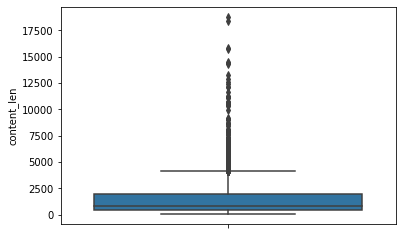

In [ ]:
import seaborn as sns
df['content_len'] = df[text_col_name].apply(lambda x: len(x))
sns.boxplot(y = df['content_len'])

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class MainData(Dataset):
  def __init__(self, df, tokenizer) -> None:
    super().__init__()
    self.tokenizer = tokenizer
    self.df = df
  
  def __getitem__(self, index):
    text = self.df.iloc[index][text_col_name]
    label = self.df.iloc[index][label_col_name]

    token = self.tokenizer(text, padding=True, truncation=True, max_length=512)

    input_ids = token['input_ids']
    token_ids = token['token_type_ids']
    attention_mask = token['attention_mask']
    label = torch.tensor(label)

    return (input_ids, token_ids, attention_mask, label)
  
  def __len__(self):
    return len(self.df)
    

In [ ]:
from torch.nn.utils.rnn import pad_sequence

def create_batch(datas):
    input_ids = [torch.Tensor(i[0]) for i in datas]
    token_type_ids = [torch.Tensor(i[1])for i in datas]
    attention_mask = [torch.Tensor(i[2]) for i in datas]
    
    if datas[0][3] is not None:
        labels = torch.stack([i[3] for i in datas])
    else:
        labels = None

    input_ids_tensors = pad_sequence(input_ids, batch_first=True)
    token_type_ids_tensors = pad_sequence(token_type_ids, batch_first=True)
    masks_tensors = pad_sequence(attention_mask, batch_first=True)

    input_ids_tensors      = input_ids_tensors.to(torch.long)
    token_type_ids_tensors = token_type_ids_tensors.to(torch.long)
    masks_tensors          = masks_tensors.to(torch.long)
    
    return input_ids_tensors, token_type_ids_tensors, masks_tensors, labels

In [ ]:
from torch import nn
from transformers.modeling_outputs import TokenClassifierOutput

class OurModel(nn.Module):
  def __init__(self, ori_model, num_labels):
    super(OurModel, self).__init__()
    self.num_labels = num_labels

    self.model = model = ori_model
    self.dropout = nn.Dropout(0.1)
    self.classifier = nn.Linear(768, num_labels)

  def forward(self, input_ids=None, attention_mask=None, labels=None):
    outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
    layers = self.dropout(outputs[0])
    logits = self.classifier(layers[:, 0, :].view(-1, 768))

    loss = None
    if labels is not None:
      loss_fct = nn.CrossEntropyLoss()
      loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
    return TokenClassifierOutput(loss=loss, logits=logits, hidden_states=outputs.hidden_states,attentions=outputs.attentions)

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoModel
import torch

In [ ]:
NAME = "uer/roberta-base-finetuned-jd-full-chinese"
cls_model = AutoModelForSequenceClassification.from_pretrained(NAME)
model = OurModel(AutoModel.from_pretrained(NAME), 32)

tokenizer = AutoTokenizer.from_pretrained(NAME)

Downloading:   0%|          | 0.00/642 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/390M [00:00<?, ?B/s]

Some weights of the model checkpoint at uer/roberta-base-finetuned-jd-full-chinese were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/295 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/107k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
from torch.utils.data import DataLoader

train_set = MainData(df, tokenizer)
train_loader = DataLoader(train_set, shuffle=False, batch_size=16, collate_fn=create_batch)

val_set = MainData(val_df, tokenizer)
val_loader = DataLoader(val_set, shuffle=False, batch_size=8, collate_fn=create_batch)

In [ ]:
test_set = MainData(test_df, tokenizer)
test_loader = DataLoader(test_set, shuffle=False, batch_size=8, collate_fn=create_batch)

In [ ]:
from sklearn.metrics import accuracy_score

def eval(model, data_loader):
  loss=0
  model.eval()
  prediction = None
  true = None

  # label_pred = []
  # label_true = []
  with torch.no_grad():
    for index, data in enumerate(data_loader):
      input_id, mark, sgement_id, label = [t.to("cuda") for t in data]
      
      #算Val_loss
      output_loss = model(input_id, mark, label)
      loss+=output_loss[0].item()
      #================================================

      output = model(input_id, mark)

      logits = output[0]
      _, pred = torch.max(logits.data, 1)

      # label_pred.extend(pred.tolist())
      # label_true.extend(label.tolist())
      # print(type(label))
      pred = pred.cpu()
      label = label.cpu()


      # print(f"True label: {label}")
      # print(f"Pred label: {pred}")
      

      if prediction is None:
        prediction = pred
        true = label
      else:
        prediction = torch.cat((prediction, pred))
        true = torch.cat((true, label))

  #=================
  loss = loss/len(data_loader)
  #=================

  acc = accuracy_score(true, prediction)
  # f1 = f1_score(true, prediction)
  # prec = precision_score(true, prediction)
  # recall = recall_score(true, prediction)

  return acc,loss

In [ ]:
from torch.optim import Adam
from torch.nn import BCELoss
import time
import sys

device = 'cuda'
model = model.to(device)
model.train()

optimizer = Adam(model.parameters(), lr=5e-5)
Train_Loss = []
Val_Loss = []
Train_Acc = []
Val_Acc = []
EPOCH = 15
start = time.time()
for epoch in range(EPOCH):
    # running_loss = 0.0
    bts = 0
    for index, data in enumerate(train_loader):
      input_id, mark, sgement_id, label = [t.to(device) for t in data]
      optimizer.zero_grad()

      output = model(input_id, mark, label)
      l = output[0]
      l.backward()
      optimizer.step()
      # running_loss+=l.item()
      bts+=1
      stats = 'Epoch [%d/%d], Step [%d/%d], Batch-Loss: %.4f' % (epoch+1, EPOCH, bts, len(train_loader), l.item())
      print('\r' + stats, end="")
      sys.stdout.flush()

    # avg_loss = running_loss/bts
    
    # loss_list.append(avg_loss)
    train_acc,train_loss = eval(model, train_loader)
    val_acc,val_loss = eval(model, val_loader)
    Train_Loss.append(train_loss)
    Val_Loss.append(val_loss)
    Train_Acc.append(train_acc)
    Val_Acc.append(val_acc)
    # print(f'val_acc: {val_acc}')
    stats = 'Epoch [%d/%d], Step [%d/%d], Train-Loss: %.4f, Val-Loss: %.4f, Train-Acc: %.4f, Val-Acc: %.4f' % (epoch+1, EPOCH, bts, len(train_loader), train_loss, val_loss, train_acc, val_acc)
    print('\r' + stats)
    
    # loss_list = np.array(loss_list)
    

end = time.time()
cost_time = end - start
print('training time', cost_time)


# model.save_pretrained("suicide_predtion_model")
# tokenizer.save_pretrained("suicide_predtion_token")

Epoch [1/15], Step [347/347], Train-Loss: 1.3436, Val-Loss: 1.2748, Train-Acc: 0.6704, Val-Acc: 0.6834
Epoch [2/15], Step [347/347], Train-Loss: 0.9152, Val-Loss: 1.1109, Train-Acc: 0.7567, Val-Acc: 0.7283
Epoch [3/15], Step [347/347], Train-Loss: 0.6194, Val-Loss: 1.2753, Train-Acc: 0.8338, Val-Acc: 0.7068
Epoch [4/15], Step [347/347], Train-Loss: 0.4392, Val-Loss: 1.2004, Train-Acc: 0.8802, Val-Acc: 0.7293
Epoch [5/15], Step [347/347], Train-Loss: 0.3600, Val-Loss: 1.2956, Train-Acc: 0.8977, Val-Acc: 0.7130
Epoch [6/15], Step [347/347], Train-Loss: 0.2266, Val-Loss: 1.3628, Train-Acc: 0.9398, Val-Acc: 0.7334
Epoch [7/15], Step [347/347], Train-Loss: 0.1714, Val-Loss: 1.3917, Train-Acc: 0.9541, Val-Acc: 0.7406
Epoch [8/15], Step [347/347], Train-Loss: 0.1897, Val-Loss: 1.4121, Train-Acc: 0.9499, Val-Acc: 0.7436
Epoch [9/15], Step [347/347], Train-Loss: 0.1402, Val-Loss: 1.4741, Train-Acc: 0.9620, Val-Acc: 0.7477
Epoch [10/15], Step [347/347], Train-Loss: 0.1211, Val-Loss: 1.4694, Trai

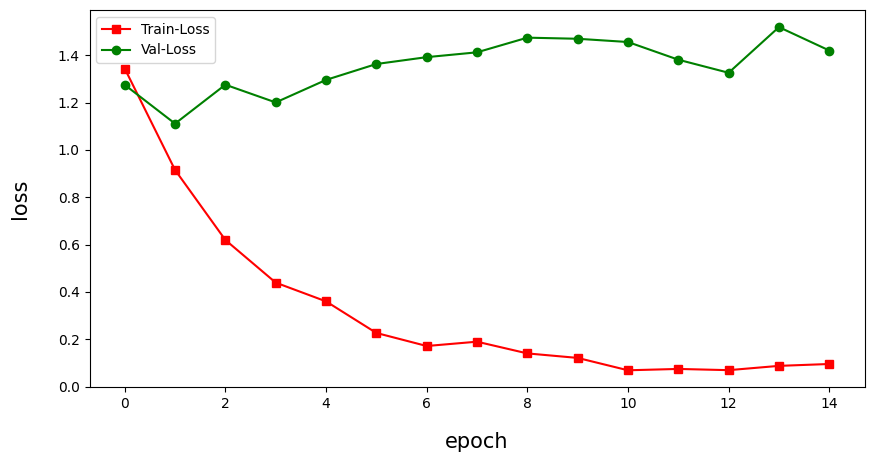

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5),dpi=100,linewidth = 2)
plt.plot(Train_Loss, 's-', color='r', label="Train-Loss")   
plt.plot(Val_Loss, 'o-', color='g', label="Val-Loss")    
plt.xlabel("epoch", fontsize=15, labelpad = 15)
plt.ylabel("loss", fontsize=15, labelpad = 20)
plt.legend(loc = "best", fontsize=10)
plt.show()

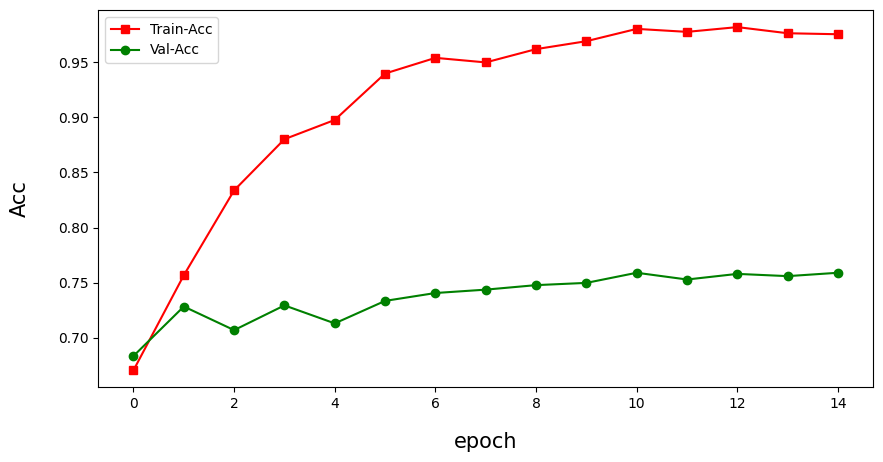

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5),dpi=100,linewidth = 2)
plt.plot(Train_Acc, 's-', color='r', label="Train-Acc")   
plt.plot(Val_Acc, 'o-', color='g', label="Val-Acc")    
plt.xlabel("epoch", fontsize=15, labelpad = 15)
plt.ylabel("Acc", fontsize=15, labelpad = 20)
plt.legend(loc = "best", fontsize=10)
plt.show()

In [ ]:
def save(model, optimizer, path):
  torch.save({
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict()
  }, path)

In [ ]:
model_save_to = 'model/roberta-base-2020CisDep-10501-20220713.zip'

In [ ]:
save(model, optimizer, model_save_to)

In [ ]:
eval(model, train_loader)

(0.9755043227665706, 0.09543801589918616)

In [ ]:
eval(model, val_loader)

(0.7589376915219612, 1.4198055732578827)

In [ ]:
eval(model, test_loader)

(0.7586206896551724, 1.3484467524001478)

In [ ]:
!